In [54]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import silence_tensorflow.auto
import tensorflow as tf




In [30]:
data_dir_train = pathlib.Path("data/train")
data_dir_test = pathlib.Path('data/test')

In [31]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2637
660


In [33]:
batch_size = 32
img_height = 180
img_width = 180

In [34]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.3,
    subset='training',
    image_size=(img_height, img_width),  
    batch_size=batch_size)

Found 3637 files belonging to 2 classes.
Using 2546 files for training.


In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.3,
    subset='validation',
    image_size=(img_height, img_width),  
    batch_size=batch_size)

Found 3637 files belonging to 2 classes.
Using 1091 files for validation.


In [36]:
class_names = train_ds.class_names
print(class_names)

['benign', 'malignant']


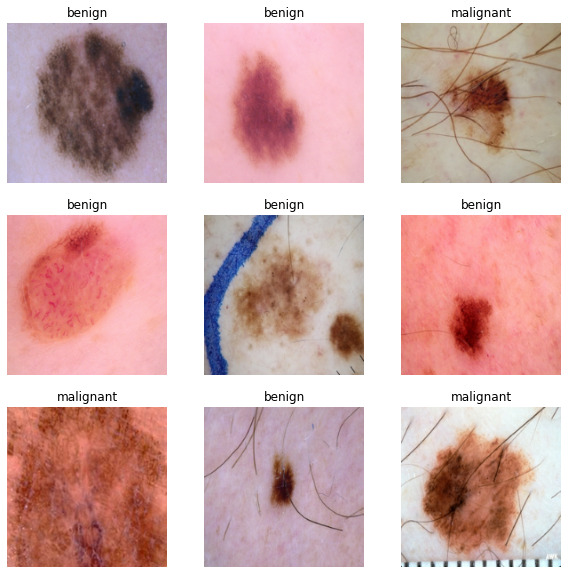

In [37]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [38]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [39]:
num_classes = 9 

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

In [42]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
80/80 [==============================] - 55s 658ms/step - loss: 0.6886 - accuracy: 0.6540 - val_loss: 0.4539 - val_accuracy: 0.7764
Epoch 2/20
80/80 [==============================] - 51s 638ms/step - loss: 0.4582 - accuracy: 0.7718 - val_loss: 0.4858 - val_accuracy: 0.7993
Epoch 3/20
80/80 [==============================] - 50s 632ms/step - loss: 0.4148 - accuracy: 0.7930 - val_loss: 0.3805 - val_accuracy: 0.8194
Epoch 4/20
80/80 [==============================] - 50s 629ms/step - loss: 0.4262 - accuracy: 0.7954 - val_loss: 0.3964 - val_accuracy: 0.8213
Epoch 5/20
80/80 [==============================] - 51s 638ms/step - loss: 0.3801 - accuracy: 0.8126 - val_loss: 0.3501 - val_accuracy: 0.8268
Epoch 6/20
80/80 [==============================] - 50s 630ms/step - loss: 0.3572 - accuracy: 0.8225 - val_loss: 0.3363 - val_accuracy: 0.8451
Epoch 7/20
80/80 [==============================] - 51s 640ms/step - loss: 0.3311 - accuracy: 0.8449 - val_loss: 0.3433 - val_accuracy: 0.8433

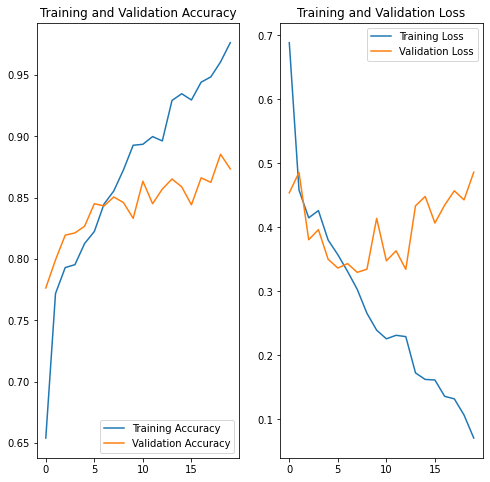

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [55]:
data_augmentation = keras.Sequential([
                                      layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.experimental.preprocessing.RandomRotation(0.1),
                                      layers.experimental.preprocessing.RandomZoom(0.1),
])

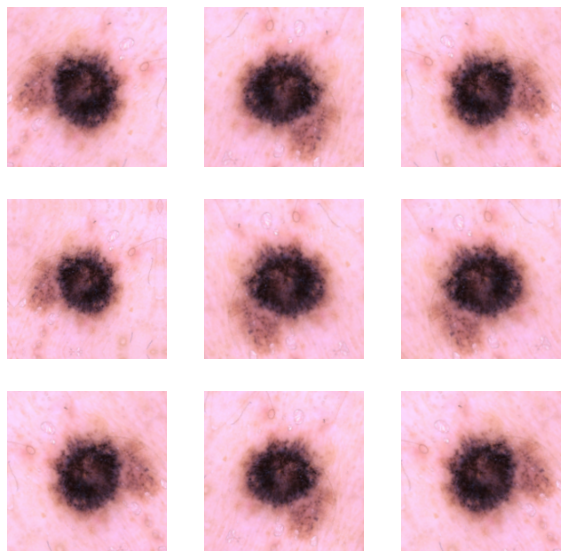

In [56]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [57]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [58]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [59]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
80/80 [==============================] - 67s 793ms/step - loss: 0.7009 - accuracy: 0.6167 - val_loss: 0.5038 - val_accuracy: 0.7745
Epoch 2/20
80/80 [==============================] - 64s 807ms/step - loss: 0.5321 - accuracy: 0.7274 - val_loss: 0.4869 - val_accuracy: 0.7351
Epoch 3/20
80/80 [==============================] - 65s 814ms/step - loss: 0.4714 - accuracy: 0.7584 - val_loss: 0.4223 - val_accuracy: 0.8130
Epoch 4/20
80/80 [==============================] - 66s 823ms/step - loss: 0.4245 - accuracy: 0.7903 - val_loss: 0.4079 - val_accuracy: 0.8002
Epoch 5/20
80/80 [==============================] - 65s 809ms/step - loss: 0.4152 - accuracy: 0.7958 - val_loss: 0.3953 - val_accuracy: 0.8048
Epoch 6/20
80/80 [==============================] - 65s 810ms/step - loss: 0.4089 - accuracy: 0.7958 - val_loss: 0.3778 - val_accuracy: 0.8158
Epoch 7/20
80/80 [==============================] - 65s 815ms/step - loss: 0.3970 - accuracy: 0.7997 - val_loss: 0.3757 - val_accuracy: 0.8148

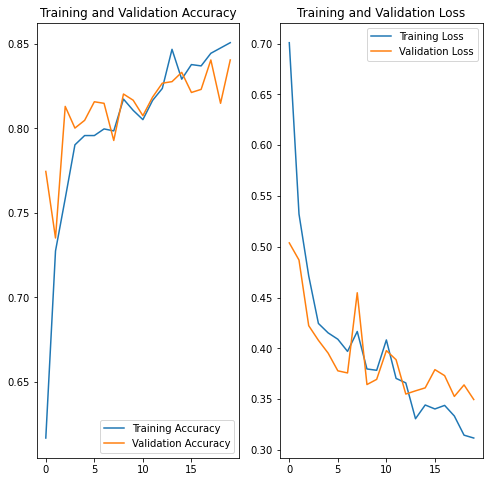

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()